# Práctica 3: Redes recurrentes para el Procesamiento del Lenguaje Natural - Aitana Villaplana Moreno
En esta práctica sen va a desarrollar diferentes sistemas para realizar una tarea de análisis de sentimientos, se desarrollarán con Redes Neuronales Recurrentes, además de trabajar con los distintos tipo de parámetros de los mismos.

La práctica consistirá en probar variaciones de distintos modelos de RNN, variando los parámetros y el número y tipo de capas. También se realizará un análisis de los resultados, y la variación entre los distintos modelos.

##1. Importación de librerías, carga y visualización de los datos
En primer lugar se importarán las librerías necesarias para el desarrollo de la práctica. En segundo lugar se cargarán los dos ficheros del conjunto de datos, subidos la carpeta del drive, el conjunto de entrenamiento (training) y el conjunto de validación (test).

In [1]:
# Procesado de datos
import pandas as pd
import numpy as np

import re
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Representación de datos
from sklearn import preprocessing

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Visualización
import matplotlib.pyplot as plt

# Clasificación
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Embedding, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# Utiles
from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Enlazamos el notebook en Colab con nuestro almacenamiento en Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se carga el dataset en un objeto de la clase pandas.

In [3]:
training_set = pd.read_csv("/content/drive/My Drive/train_reviews.csv", quotechar='"', header=0, sep=",")
test_set = pd.read_csv("/content/drive/My Drive/test_reviews.csv", quotechar='"', header=0, sep=",")

dataset = pd.concat([training_set,test_set])

Debido a que se trata del mismo conjunto de datos que en la práctica pasada, se va a omitir el análisis y representación de los datos, realizados en la Práctica 1.

## 2. Pre-procesado de datos y representación
Después de haber analizado los datos, es necesario realizar un pre-procesado de éstos, se aplicarán una serie de técnicas:

1. Eliminación de carácteres no alfanuméricos 
2. Eliminación de *stopwords*
3. Lematización
4. *Stemming*

Posteriormente, dichos datos se introducirán en el modelo y se transformarán en vectores mediante una capa de Emebedding.

### 2.1 Pre-procesamiento
En este apartado se tokenizará el texto, llevando a cabo las técnicas descritas anteriormente, como eliminación de *stopwords*, lematización y *stemming*. Todos estos procesos se realizan en la función `process_text`, y posteriormente se aplicará a las reviews.



In [4]:
def process_text(text_serie):
  #Eliminación de carácteres no alfanuméricos y carácter <br \/>
  alphanumeric_text = re.sub("<br \/>", "", text_serie) 
  alphanumeric_text = re.sub("[^0-9a-zA-Z]+", " ", alphanumeric_text) 

  #Conversión texto a minúsculas y tokenización a lista de palabras
  tokens = alphanumeric_text.lower().split()
  
  #Eliminación las stopwords
  stop_words = set(stopwords.words("english")) 
  tokens_without_stopwords = [token for token in tokens if token not in stop_words]
  
  #Lematización
  wordnet_lemmatizer = WordNetLemmatizer()
  tokens_lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens_without_stopwords]
  
  #Stemming
  stemmer = PorterStemmer()
  tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmas]
  
  return tokens_stemmed

dataset["review_processed"] = dataset["review"].apply(process_text)
dataset["review_processed"]

0       [peopl, tri, make, believ, premis, rubbishi, s...
1       [want, see, cut, sinc, day, heard, sometim, la...
2       [movi, terribl, suspens, spent, wait, point, m...
3       [hope, keep, act, direct, sure, task, could, e...
4       [fell, love, silent, action, drama, kurt, russ...
                              ...                        
1995    [order, hold, public, attent, three, hour, tre...
1996    [skeptic, sacrif, preciou, time, watch, film, ...
1997    [lol, deliri, funni, tear, eddi, murphi, impre...
1998    [kinda, interest, movi, trashi, cannib, flick,...
1999    [zodiac, killer, 1, 10, worst, act, ever, real...
Name: review_processed, Length: 10000, dtype: object

### 2.2 Representación
Una vez se ha obtenido y procesado el conjunto de tokens de cada review, el siguiente paso es representar con valores tanto las palabras como las etiquetas, para introducir en el modelo que se entrene en los apartados siguientes.

Para el caso de las etiquetas, debido a que se trata de una clasificación binaria (entre 2 clases), es razonable utilizar una representación de 1s y 0s.
Como en las dos prácticas anteriores.

Basándonos en los resultados de las prácticas anteriores, no se va a realizar ninguna representación de los datos de entrada, si no que se pasarán las reviews tokenizadas directamente al modelo, que contará con una capa de entrada de Embedding.


In [5]:
# Se vuelve a separar los datos en entrenamiento y test
X_train = dataset[0:len(training_set)][["id", "review_processed"]]
y_train = dataset[0:len(training_set)][["sentiment"]]
X_test = dataset[len(training_set):len(dataset)][["id", "review_processed"]]
y_test = dataset[len(training_set):len(dataset)][["sentiment"]]

In [6]:
# Se transforman las etiquetas a valores numéricos, para esre caso, clases binarias 0 (negativo) y 1 (positivo)
le = preprocessing.LabelEncoder()
binary_y_train = le.fit_transform(y_train["sentiment"].values)
binary_y_test = le.fit_transform(y_test["sentiment"].values)

In [7]:
# Vector de etiquetas -> matriz de etiquetas
tensor_y_train = to_categorical(binary_y_train, num_classes=2)
tensor_y_test = to_categorical(binary_y_test, num_classes=2)
print("Vector de etiquetas: ", binary_y_train)
print("Matriz de etiquetas: \n", tensor_y_train)

Vector de etiquetas:  [0 1 0 ... 0 0 0]
Matriz de etiquetas: 
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## 3. Redes Neuronales Convolucionales (RNN)

Una vez realizado el pre-procesamiento, se puede empezar a pensar en un modelo apropiado para realizar la tarea de Clasificación. Las Redes Neuronales Recurrentes son arquitecturas basadas en secuencias de datos, en las cuales importa el orden de dicha secuencia, como por ejemplo el texto. Estas redes, tienen en cuenta tanto la entrada, como las entradas anteriores del modelo, lo que facilita mucho tareas de reconocimiento de texto, ya que se tiene en cuenta el contexto.

Las redes recurrentes tienen varias arquitecturas según la tarea que se vaya a desempeñar, en nuestro caso, al ser una tarea de clasificación de análisis de sentimiento, con un único valor de salida, la arquitectura será de varias entradas y una salida (*many-to-one*).

Las distintas capas que se van a probar son los siguientes:
*   Capa simple de RNN
*   Capa de GRU
*   Capa de LSTM
*   Capas apiladas de los 3 modelos anteriores
*   Capa Bidirectional de los 3 modelos anteriores
*   Afinado del modelo


La función `plot_loss_accuracy_training` muestra de forma gráfica el desarrollo de los valores de *accucary* y pérdida a lo largo de todas las *epoch* de entrenamiento.

In [8]:
def plot_loss_accuracy_training(history):
  print(history.history.keys())
  
  fig = plt.figure(figsize = (6, 6))
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)

  # Gráfica de la accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy', fontsize=20)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  fig = plt.figure(figsize = (6, 6))
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  
  # Gráfica de la pérdida
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss', fontsize=20)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

La función `evaluate_nn_classifier` evalúa el modelo creado, con las métricas de precisión, *recall*, y *f1score*.

In [9]:
def evaluate_nn_classifier(X, y, model):
  yhat = model.predict(X)
  yhat = np.argmax(yhat, axis=1)

  precision_ = precision_score(y, yhat)
  recall_ = recall_score(y, yhat)
  f1score_ = f1_score(y, yhat)

  print("Precision: %0.3f Recall %0.3f F1 score: %0.3f for %s" % (precision_, recall_, f1score_, "Neuronal Network"))

Definimos las constantes para todas las RNN que vamos a entrenar.

In [10]:
# Número de épocas (iteraciones globales)
epochs = 40
# Tamaño de batch (lote)
batch_size = 32
#Máxima longitud del documento
max_len = 512

# Características de los datos
emb_dim = 100
classes = 2

Debido al tiempo tan largo de entrenamiento cuando el modelo tienen una capa de Embeddings, se han añadido dos condiciones de parada para el modelo (*early stopping*), para la *accuracy* y pérdida del conjunto de validación, con una paciencia de 5 (si la *accuracy* o la pérdida empeoran 5 *epoch* seguidas el modelo deja de entrenar.

In [11]:
early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping_acc = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

Se tokenizan los datos, y se aplica el *padding* para posteriormente pasarlos al modelo.

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['review_processed'])

# Se transforman a secuencias numéricas (secuencia de palabras -> secuencia de números)
sequences_train = tokenizer.texts_to_sequences(X_train['review_processed'])
sequences_test = tokenizer.texts_to_sequences(X_test['review_processed'])

# Es necesario que ambas tengan la misma longitud
tensor_x_train = pad_sequences(sequences_train, maxlen=max_len)
tensor_x_test = pad_sequences(sequences_test, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1
print(tensor_x_train.shape)

(8000, 512)


### 3.1 Capa simple de RNN (SimpleRNN)

En primer lugar, se probará a realizar el modelo con una única capa simple de RNN, sin apilar. El número de neuronas seleccionado es la dimensión del emedding, para que cada neurona se encargue de una característica.

Se utilizará el optimizador RMSProp debido a que se considera uno de los que mejor funciona en RNN.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
model.add(SimpleRNN(units=emb_dim))
model.add(Dense(classes, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,238,402
Trainable params: 3,238,402
Non-trainable params: 0
_________________________________________________________________


En primer lugar, se ejecutará el modelo sin los callbacks, para verificar la evolución completa del modelo de las 40 epoch.

In [ ]:
history = model.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1)

Epoch 1/40
200/200 [==============================] - 41s 203ms/step - loss: 0.0404 - acc: 0.9859 - val_loss: 0.6622 - val_acc: 0.7763
Epoch 2/40
200/200 [==============================] - 37s 187ms/step - loss: 0.0281 - acc: 0.9909 - val_loss: 0.8171 - val_acc: 0.7887
Epoch 3/40
200/200 [==============================] - 38s 188ms/step - loss: 0.0297 - acc: 0.9912 - val_loss: 0.7669 - val_acc: 0.7975
Epoch 4/40
200/200 [==============================] - 44s 221ms/step - loss: 0.0779 - acc: 0.9800 - val_loss: 1.0295 - val_acc: 0.7831
Epoch 5/40
200/200 [==============================] - 47s 235ms/step - loss: 0.1453 - acc: 0.9681 - val_loss: 1.1258 - val_acc: 0.7669
Epoch 6/40
200/200 [==============================] - 38s 188ms/step - loss: 0.0510 - acc: 0.9822 - val_loss: 0.8372 - val_acc: 0.7606
Epoch 7/40
200/200 [==============================] - 38s 192ms/step - loss: 0.0398 - acc: 0.9881 - val_loss: 0.9786 - val_acc: 0.7794
Epoch 8/40
200/200 [==============================] - 3

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


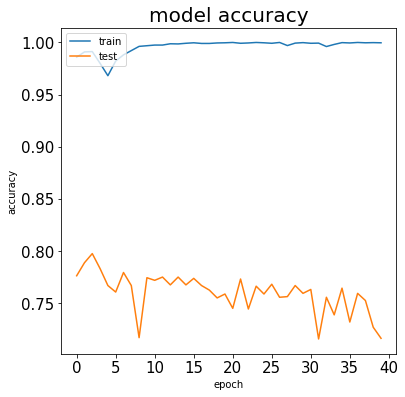

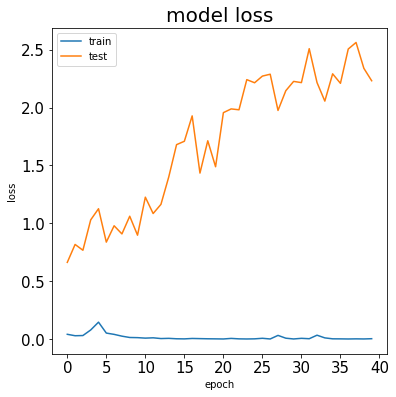

In [ ]:
plot_loss_accuracy_training(history)

Tal y como se observa en la gráfica del loss, existe un sobre ajuste, ya que se está aumentando la pérdida a medida que transcurren las epoch, y la accuracy se mantiene más o menos constante durante el entrenamiento. A pesar del sobre ajuste, los resultados no son malos, con un 74.5% de F1.


In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, model)

Precision: 0.724 Recall 0.768 F1 score: 0.745 for Neuronal Network


Para tratar de evitar esto, se añade dropout regular del 20% (este dropout afecta a la entrada y salida de la capa) en la capa y un dropout recurrente del 25% (este dropout afecta a las conexiones entre las neuronas recurrentes).

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
model.add(SimpleRNN(units=emb_dim, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(classes, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,238,402
Trainable params: 3,238,402
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1)

Epoch 1/40
200/200 [==============================] - 55s 262ms/step - loss: 0.7182 - acc: 0.4995 - val_loss: 0.6892 - val_acc: 0.5344
Epoch 2/40
200/200 [==============================] - 51s 253ms/step - loss: 0.6994 - acc: 0.5423 - val_loss: 0.6906 - val_acc: 0.5181
Epoch 3/40
200/200 [==============================] - 48s 238ms/step - loss: 0.6859 - acc: 0.5577 - val_loss: 0.6693 - val_acc: 0.5800
Epoch 4/40
200/200 [==============================] - 47s 236ms/step - loss: 0.6482 - acc: 0.6272 - val_loss: 0.6386 - val_acc: 0.6306
Epoch 5/40
200/200 [==============================] - 48s 241ms/step - loss: 0.5889 - acc: 0.7008 - val_loss: 0.6061 - val_acc: 0.6637
Epoch 6/40
200/200 [==============================] - 47s 235ms/step - loss: 0.5278 - acc: 0.7470 - val_loss: 0.5916 - val_acc: 0.6681
Epoch 7/40
200/200 [==============================] - 47s 237ms/step - loss: 0.4521 - acc: 0.7945 - val_loss: 0.5493 - val_acc: 0.7394
Epoch 8/40
200/200 [==============================] - 4

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


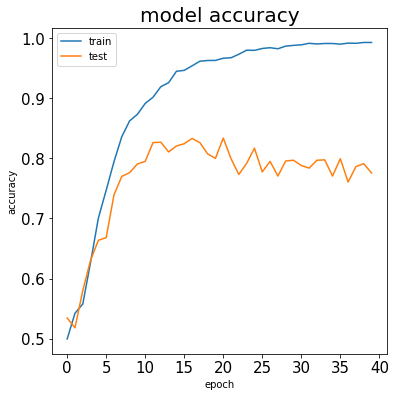

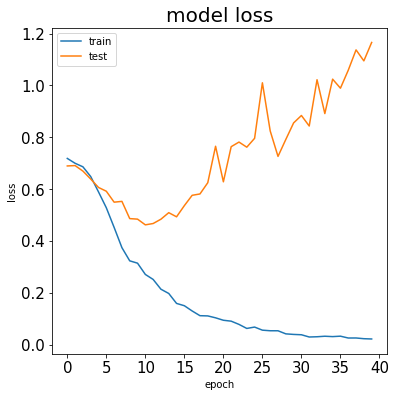

In [ ]:
plot_loss_accuracy_training(history)

Aplicando el dropout, se ve una mejoría en los resultados de la evaluación, pero se observa un sobre ajuste a partir de la epoch 15 aproximadamente, por lo que ahora se van a utilizar los callbacks definidos anteriormente para tratar de evitar este sobre ajuste y realizar menor número de epoch.

En este caso la F1 ha mejorado un 2%, llegando a un 76.5%.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, model)

Precision: 0.755 Recall 0.775 F1 score: 0.765 for Neuronal Network


In [ ]:
history = model.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 62s 310ms/step - loss: 0.0201 - acc: 0.9937 - val_loss: 1.2352 - val_acc: 0.7500
Epoch 2/40
200/200 [==============================] - 47s 236ms/step - loss: 0.0174 - acc: 0.9948 - val_loss: 1.5301 - val_acc: 0.7538
Epoch 3/40
200/200 [==============================] - 53s 264ms/step - loss: 0.0209 - acc: 0.9942 - val_loss: 1.1834 - val_acc: 0.7831
Epoch 4/40
200/200 [==============================] - 47s 237ms/step - loss: 0.0146 - acc: 0.9950 - val_loss: 1.2800 - val_acc: 0.7681
Epoch 5/40
200/200 [==============================] - 49s 244ms/step - loss: 0.0173 - acc: 0.9953 - val_loss: 1.2292 - val_acc: 0.7600
Epoch 6/40
200/200 [==============================] - 48s 238ms/step - loss: 0.0158 - acc: 0.9942 - val_loss: 1.2352 - val_acc: 0.7837
Epoch 7/40
200/200 [==============================] - 48s 242ms/step - loss: 0.0116 - acc: 0.9970 - val_loss: 1.2646 - val_acc: 0.7900
Epoch 8/40
200/200 [==============================] - 4

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


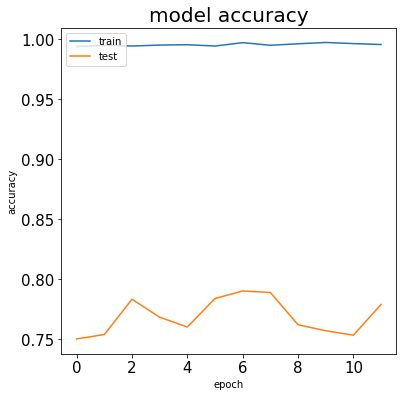

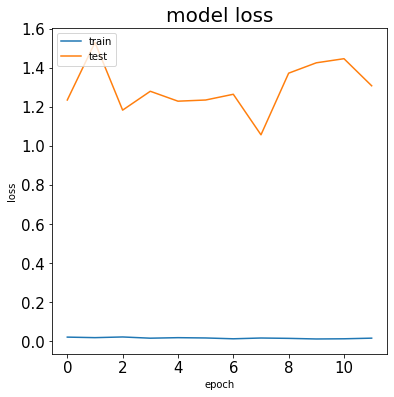

In [ ]:
plot_loss_accuracy_training(history)

Tras aplicar los callbacks de parada, se oberva una mejoría en los resultados, con casi un 78% de F1. El modelo se ha detenido a las 12 epoch, aproximadamente cuando empezaba a producirse el sobre ajuste.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, model)

Precision: 0.768 Recall 0.790 F1 score: 0.779 for Neuronal Network


### 3.2 Capa de GRU

Una vez probadas la capa simple de RNN, se va a probar la capa GRU (Gated Recurrent Unit), que utilizan una especie de "memoria" para ser capaces de retener el contexto. Debido a esto, esta capa tiene más parámetros que entrenar, 60.600 de la capa de GRU, frente a 20.100 de la RNN simple.

Lo que hace que el entrenamiento se más lento, pero al ser un modelo más complejo debería tener mejores resultados.

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
gru_model.add(GRU(units=emb_dim, dropout=0.2, recurrent_dropout=0.25))
gru_model.add(Dense(classes, activation='sigmoid'))

gru_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
gru_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_6 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,278,902
Trainable params: 3,278,902
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = gru_model.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 424s 2s/step - loss: 0.4927 - acc: 0.7458 - val_loss: 0.3709 - val_acc: 0.8481
Epoch 2/40
200/200 [==============================] - 386s 2s/step - loss: 0.2477 - acc: 0.9083 - val_loss: 0.3564 - val_acc: 0.8587
Epoch 3/40
200/200 [==============================] - 382s 2s/step - loss: 0.1551 - acc: 0.9452 - val_loss: 0.3949 - val_acc: 0.8375
Epoch 4/40
200/200 [==============================] - 381s 2s/step - loss: 0.1088 - acc: 0.9625 - val_loss: 0.4002 - val_acc: 0.8481
Epoch 5/40
200/200 [==============================] - 378s 2s/step - loss: 0.0707 - acc: 0.9781 - val_loss: 0.4243 - val_acc: 0.8512
Epoch 6/40
200/200 [==============================] - 380s 2s/step - loss: 0.0421 - acc: 0.9853 - val_loss: 0.5266 - val_acc: 0.8556
Epoch 7/40
200/200 [==============================] - 384s 2s/step - loss: 0.0314 - acc: 0.9917 - val_loss: 0.6801 - val_acc: 0.8487


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


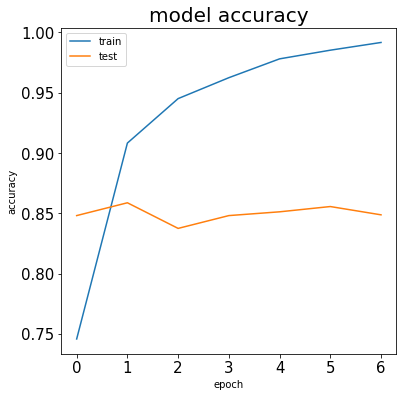

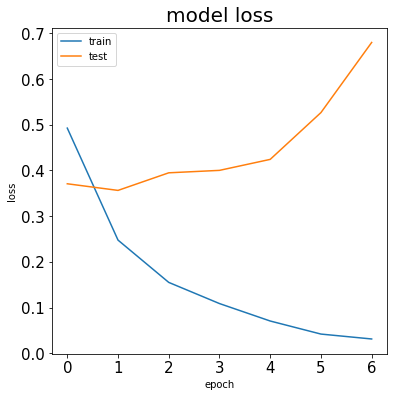

In [ ]:
plot_loss_accuracy_training(history)

Tal y como se esperaba, los resultados son significativamente mejores, con un F1 del 85.5%. A pesar del dropout y los callbacks, se ve como el modelo sigue aumentando la pérdida en las últimas epoch.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, gru_model)

Precision: 0.862 Recall 0.849 F1 score: 0.855 for Neuronal Network


### 3.3 Capa de LSTM

Finalmente, se va a probar la capa más compleja y con mayor número de parámetros, LSTM (Long Short-Term Memory), que cuenta con una estructura ligeramente más compleja de que la GRU, ya que tiene una celda de memoria, lo que supone entrenar 80.400 parámteros, frente a los 60.600 de la GRU, y los 20.100 de la capa simple.

La capa LSTM puede acumular información tanto a corto como a largo plazo. Lo que hace que el entrenamiento se más lento, pero al ser un modelo más complejo debería tener mejores resultados.

Para tratar de solventar una vez más el problema del sobre ajuste, se ha aumentado el dropout recurrente (entre neuronas) del 25% al 50%.

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
lstm_model.add(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5))
lstm_model.add(Dense(classes, activation='sigmoid'))

lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 512, 100)          3218100   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 2)                 202       
                                                                 
Total params: 3,298,702
Trainable params: 3,298,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 218s 1s/step - loss: 0.4978 - acc: 0.7661 - val_loss: 0.3456 - val_acc: 0.8569
Epoch 2/40
200/200 [==============================] - 207s 1s/step - loss: 0.2444 - acc: 0.9078 - val_loss: 0.3298 - val_acc: 0.8669
Epoch 3/40
200/200 [==============================] - 204s 1s/step - loss: 0.1533 - acc: 0.9484 - val_loss: 0.3987 - val_acc: 0.8575
Epoch 4/40
200/200 [==============================] - 208s 1s/step - loss: 0.1083 - acc: 0.9639 - val_loss: 0.4659 - val_acc: 0.8500
Epoch 5/40
200/200 [==============================] - 205s 1s/step - loss: 0.0748 - acc: 0.9762 - val_loss: 0.4971 - val_acc: 0.8600
Epoch 6/40
200/200 [==============================] - 205s 1s/step - loss: 0.0542 - acc: 0.9819 - val_loss: 0.4688 - val_acc: 0.8537
Epoch 7/40
200/200 [==============================] - 205s 1s/step - loss: 0.0381 - acc: 0.9884 - val_loss: 0.5929 - val_acc: 0.8550


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


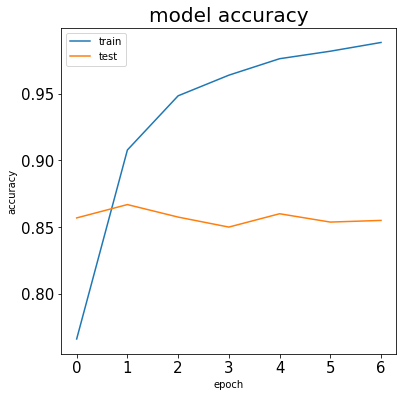

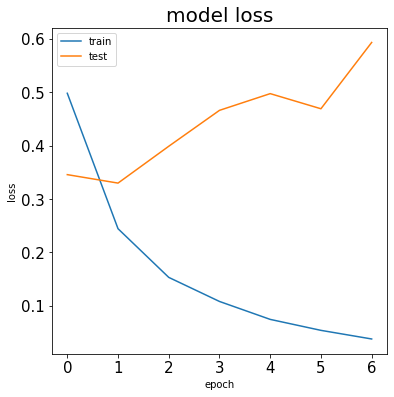

In [ ]:
plot_loss_accuracy_training(history)

En esta ocasión los resultados no varían mucho respecto a la capa GRU, obteniendo un F1 del 86.5%, un 1% más que en el caso anterior.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, lstm_model)

Precision: 0.858 Recall 0.871 F1 score: 0.865 for Neuronal Network


### 3.4 Capas apiladas

Una vez probados los modelos con una única capa recurrente. Se va a probar a añadir más de una capa apilada, es decir, la salida de la capa será la entrada de otra capa, con el fin de ver si los resultados mejoran. Cabe destacar que el número de parámetros del modelo aumentará, ya que se utilizarán el doble de parámetros en las capas recurrentes.

#### 3.4.1 Capas Simples apiladas

En este caso se va a probar a utilizar dos capas Simples RNN aplidas, ambas con los mismos hiperparámetros.

In [ ]:
simple_model_stacked = Sequential()
simple_model_stacked.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
simple_model_stacked.add(SimpleRNN(units=emb_dim, dropout=0.2, recurrent_dropout=0.5, return_sequences=True))
simple_model_stacked.add(SimpleRNN(units=emb_dim, dropout=0.2, recurrent_dropout=0.5))
simple_model_stacked.add(Dense(classes, activation='sigmoid'))

simple_model_stacked.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
simple_model_stacked.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          3218100   
                                                                 
 simple_rnn (SimpleRNN)      (None, 512, 100)          20100     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 3,258,502
Trainable params: 3,258,502
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = simple_model_stacked.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 99s 463ms/step - loss: 0.7440 - acc: 0.4975 - val_loss: 0.7009 - val_acc: 0.5019
Epoch 2/40
200/200 [==============================] - 92s 458ms/step - loss: 0.7117 - acc: 0.4992 - val_loss: 0.6986 - val_acc: 0.4881
Epoch 3/40
200/200 [==============================] - 88s 439ms/step - loss: 0.7054 - acc: 0.5053 - val_loss: 0.6943 - val_acc: 0.5000
Epoch 4/40
200/200 [==============================] - 101s 507ms/step - loss: 0.7025 - acc: 0.5055 - val_loss: 0.6946 - val_acc: 0.5031
Epoch 5/40
200/200 [==============================] - 87s 433ms/step - loss: 0.7026 - acc: 0.5052 - val_loss: 0.7038 - val_acc: 0.4831
Epoch 6/40
200/200 [==============================] - 86s 432ms/step - loss: 0.7022 - acc: 0.5039 - val_loss: 0.7094 - val_acc: 0.4831
Epoch 7/40
200/200 [==============================] - 87s 433ms/step - loss: 0.7006 - acc: 0.5044 - val_loss: 0.7041 - val_acc: 0.4831
Epoch 8/40
200/200 [==============================] - 

Tal y como se observa, los resultados son muy malos, con un 27.5% de F1. Es posible que esta capa no esté diseñada para procesar los datos de salida de otra capa, lo que haya ensuciado mucho los datos para realizar la tarea de clasificación.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, simple_model_stacked)

Precision: 0.536 Recall 0.185 F1 score: 0.275 for Neuronal Network


#### 3.4.2 Capas GRU apiladas

En este caso se va a probar a utilizar dos capas GRU aplidas, ambas con los mismos hiperparámetros.

In [ ]:
gru_model_stacked = Sequential()
gru_model_stacked.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
gru_model_stacked.add(GRU(units=emb_dim, dropout=0.2, recurrent_dropout=0.5, return_sequences=True))
gru_model_stacked.add(GRU(units=emb_dim, dropout=0.2, recurrent_dropout=0.5))
gru_model_stacked.add(Dense(classes, activation='sigmoid'))

gru_model_stacked.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
gru_model_stacked.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 gru_5 (GRU)                 (None, 512, 100)          60600     
                                                                 
 gru_6 (GRU)                 (None, 100)               60600     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,339,502
Trainable params: 3,339,502
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = gru_model_stacked.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 393s 2s/step - loss: 0.5031 - acc: 0.7448 - val_loss: 0.4218 - val_acc: 0.8169
Epoch 2/40
200/200 [==============================] - 377s 2s/step - loss: 0.2730 - acc: 0.8928 - val_loss: 0.3540 - val_acc: 0.8494
Epoch 3/40
200/200 [==============================] - 377s 2s/step - loss: 0.1732 - acc: 0.9370 - val_loss: 0.3671 - val_acc: 0.8456
Epoch 4/40
200/200 [==============================] - 376s 2s/step - loss: 0.1313 - acc: 0.9559 - val_loss: 0.3789 - val_acc: 0.8481
Epoch 5/40
200/200 [==============================] - 376s 2s/step - loss: 0.0890 - acc: 0.9730 - val_loss: 0.4444 - val_acc: 0.8494
Epoch 6/40
200/200 [==============================] - 378s 2s/step - loss: 0.0592 - acc: 0.9808 - val_loss: 0.5781 - val_acc: 0.8419
Epoch 7/40
200/200 [==============================] - 375s 2s/step - loss: 0.0357 - acc: 0.9883 - val_loss: 0.6128 - val_acc: 0.8519


Como se observa, se ha obtenido un 85.8% de F1. Los resultados no son mucho mejores a los obtenidos con una única capa GRU 85.5%, por lo que añadir una capa apilada ha mejorado los resultados un 0.3%.

Teniendo en cuenta el aumento del número de parámetros, se puede asumir que no es beneficioso añadir una capa apilada en terminos de eficiencia.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, gru_model_stacked)

Precision: 0.857 Recall 0.859 F1 score: 0.858 for Neuronal Network


#### 3.4.3 Capas LSTM apiladas

Para el caso anterior, no se han observado mejoras significativas al apilar dos capas, ahora se va a probar a apilar dos capas LSTM aumentando el número de unidades en la segunda capa a 200 en lugar de 100.

In [ ]:
lstm_model_stacked = Sequential()
lstm_model_stacked.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
lstm_model_stacked.add(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5, return_sequences=True))
lstm_model_stacked.add(LSTM(units=200, dropout=0.2, recurrent_dropout=0.5))
lstm_model_stacked.add(Dense(classes, activation='sigmoid'))

lstm_model_stacked.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
lstm_model_stacked.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          3218100   
                                                                 
 lstm (LSTM)                 (None, 512, 100)          80400     
                                                                 
 lstm_1 (LSTM)               (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 3,539,702
Trainable params: 3,539,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model_stacked.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 821s 4s/step - loss: 0.4835 - acc: 0.7614 - val_loss: 0.3966 - val_acc: 0.8288
Epoch 2/40
200/200 [==============================] - 801s 4s/step - loss: 0.2387 - acc: 0.9122 - val_loss: 0.3665 - val_acc: 0.8363
Epoch 3/40
200/200 [==============================] - 798s 4s/step - loss: 0.1570 - acc: 0.9469 - val_loss: 0.3993 - val_acc: 0.8213
Epoch 4/40
200/200 [==============================] - 797s 4s/step - loss: 0.1131 - acc: 0.9642 - val_loss: 0.4655 - val_acc: 0.8606
Epoch 5/40
200/200 [==============================] - 799s 4s/step - loss: 0.0747 - acc: 0.9736 - val_loss: 0.5199 - val_acc: 0.8519
Epoch 6/40
200/200 [==============================] - 788s 4s/step - loss: 0.0505 - acc: 0.9867 - val_loss: 0.5679 - val_acc: 0.8531
Epoch 7/40
200/200 [==============================] - 796s 4s/step - loss: 0.0368 - acc: 0.9884 - val_loss: 0.6359 - val_acc: 0.8400


Apilando dos capas LSTM se ha obtenido un F1 de 84.5%, frente al 86.5% obtenido con una única capa LSTM, por lo que no es conveniente apilar dos capas en este caso. Además del tiempo extra de entrenamiento, debido al aumento del número de parámetros.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, lstm_model_stacked)

Precision: 0.855 Recall 0.835 F1 score: 0.845 for Neuronal Network


### 3.5 Capas bidireccionales

Una de las desventajas de las redes recurrentes, es que leen la información de forma secuencial en el tiempo, es decir, en en orden, pero no tienen en cuenta las palabras del contexto posterior, solo las anteriores.

Para ello, existen las capas bidireccionales, que permiten que el modelo tenga dos entradas, una entrada en el orden secuencial, y la otra en el orden inverso, para el caso del texto, sería como introducir el texto de derecha a izquierda.

Esto se hace con el fin de utilizar las dependencias y el conexto en ambos sentidos, para asi captar ciertas características que no se obtendrían solo de forma secuencial.

Se va a proceder a probar capas bidireccionales con las 3 capas descritas anteriormente.

#### 3.5.1 Capa bidireccional de capas simples


In [ ]:
simple_model_bidirectional = Sequential()
simple_model_bidirectional.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
simple_model_bidirectional.add(Bidirectional(SimpleRNN(units=emb_dim, dropout=0.2, recurrent_dropout=0.5)))
simple_model_bidirectional.add(Dense(classes, activation='sigmoid'))

simple_model_bidirectional.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
simple_model_bidirectional.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              40200     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 3,258,702
Trainable params: 3,258,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = simple_model_bidirectional.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 101s 480ms/step - loss: 0.7433 - acc: 0.5103 - val_loss: 0.6964 - val_acc: 0.4981
Epoch 2/40
200/200 [==============================] - 87s 435ms/step - loss: 0.7288 - acc: 0.5095 - val_loss: 0.6997 - val_acc: 0.4794
Epoch 3/40
200/200 [==============================] - 88s 438ms/step - loss: 0.7132 - acc: 0.5017 - val_loss: 0.6975 - val_acc: 0.4938
Epoch 4/40
200/200 [==============================] - 88s 440ms/step - loss: 0.7085 - acc: 0.4998 - val_loss: 0.6962 - val_acc: 0.4794
Epoch 5/40
200/200 [==============================] - 87s 433ms/step - loss: 0.7024 - acc: 0.4922 - val_loss: 0.6937 - val_acc: 0.5019
Epoch 6/40
200/200 [==============================] - 86s 431ms/step - loss: 0.6988 - acc: 0.5048 - val_loss: 0.6930 - val_acc: 0.5150
Epoch 7/40
200/200 [==============================] - 86s 428ms/step - loss: 0.6975 - acc: 0.5008 - val_loss: 0.6945 - val_acc: 0.4969
Epoch 8/40
200/200 [==============================] - 

Se puede ver que los resultados no soy muy buenos, aun así son mejores que los de obtenidos apilando las 2 capas, pero inferiores a los obtenidos con una única capa simple. Por lo que en para el caso de la capa simple parece que lo más conveniente en este caso es utilizar una única capa.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, simple_model_bidirectional)

Precision: 0.488 Recall 0.561 F1 score: 0.522 for Neuronal Network


#### 3.5.2 Capa bidireccional de capas GRU

In [ ]:
gru_model_bidirectional = Sequential()
gru_model_bidirectional.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
gru_model_bidirectional.add(Bidirectional(GRU(units=emb_dim, dropout=0.2, recurrent_dropout=0.5)))
gru_model_bidirectional.add(Dense(classes, activation='sigmoid'))

gru_model_bidirectional.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
gru_model_bidirectional.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          3218100   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              121200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 3,339,702
Trainable params: 3,339,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = gru_model_bidirectional.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 437s 2s/step - loss: 0.5058 - acc: 0.7483 - val_loss: 0.4216 - val_acc: 0.8356
Epoch 2/40
200/200 [==============================] - 401s 2s/step - loss: 0.2683 - acc: 0.9019 - val_loss: 0.5779 - val_acc: 0.8087
Epoch 3/40
200/200 [==============================] - 400s 2s/step - loss: 0.1866 - acc: 0.9341 - val_loss: 0.4393 - val_acc: 0.8537
Epoch 4/40
200/200 [==============================] - 398s 2s/step - loss: 0.1209 - acc: 0.9581 - val_loss: 0.3935 - val_acc: 0.8375
Epoch 5/40
200/200 [==============================] - 399s 2s/step - loss: 0.0843 - acc: 0.9727 - val_loss: 0.4903 - val_acc: 0.8269
Epoch 6/40
200/200 [==============================] - 392s 2s/step - loss: 0.0687 - acc: 0.9780 - val_loss: 0.5809 - val_acc: 0.8388
Epoch 7/40
200/200 [==============================] - 397s 2s/step - loss: 0.0512 - acc: 0.9847 - val_loss: 0.5838 - val_acc: 0.8587
Epoch 8/40
200/200 [==============================] - 405s 2s/step - 

En este caso los resultados son de un 85.1% de F1, frente a un 85.8% en el caso de las dos capas apliadas, y un 85.5 en el caso de una sola capa.

Los resultados no varían demasiado en ninguno de los 3 casos, aun así el mejor resultado se ha dado apilando dos capas GRU. Sin embargo, teniendo en cuenta el tiempo y número de parámetros a entrenar, el modelo de 1 capa parace ser la mejor opción en cuanto a eficiencia.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, gru_model_bidirectional)

Precision: 0.845 Recall 0.856 F1 score: 0.851 for Neuronal Network


#### 3.5.3 Capa bidireccional de capas LSTM


In [ ]:
lstm_model_bidirectional = Sequential()
lstm_model_bidirectional.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
lstm_model_bidirectional.add(Bidirectional(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5)))
lstm_model_bidirectional.add(Dense(classes, activation='sigmoid'))

lstm_model_bidirectional.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
lstm_model_bidirectional.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 3,379,302
Trainable params: 3,379,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model_bidirectional.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 435s 2s/step - loss: 0.4898 - acc: 0.7641 - val_loss: 0.3934 - val_acc: 0.8256
Epoch 2/40
200/200 [==============================] - 429s 2s/step - loss: 0.2444 - acc: 0.9117 - val_loss: 0.3437 - val_acc: 0.8537
Epoch 3/40
200/200 [==============================] - 428s 2s/step - loss: 0.1592 - acc: 0.9453 - val_loss: 0.3809 - val_acc: 0.8650
Epoch 4/40
200/200 [==============================] - 424s 2s/step - loss: 0.1056 - acc: 0.9619 - val_loss: 0.5011 - val_acc: 0.8544
Epoch 5/40
200/200 [==============================] - 422s 2s/step - loss: 0.0726 - acc: 0.9752 - val_loss: 0.5836 - val_acc: 0.8606
Epoch 6/40
200/200 [==============================] - 425s 2s/step - loss: 0.0587 - acc: 0.9827 - val_loss: 0.5222 - val_acc: 0.8487
Epoch 7/40
200/200 [==============================] - 424s 2s/step - loss: 0.0440 - acc: 0.9872 - val_loss: 0.5967 - val_acc: 0.8394


Se ha obtenido un F1 de 84.9% utilizando una capa bidireccional de LSTM, frente al 84.5% obtenido de apilar dos LSTM, por lo que se han obtenido mejores resultados. A pesar de esto, con una única capa LSTM se obtuvo un F1 de 86.5%, por lo que parece sigue siendo mejor opción la de utilizar una única capa.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, lstm_model_bidirectional)

Precision: 0.895 Recall 0.807 F1 score: 0.849 for Neuronal Network


### 3.6 Afinado del modelo

Tras obserar los resultados de los apartados anteriores. Se ha visto que el modelo con mejor F1 es una única capa de LTSM, con un F1 del 86.5%.

A pesar de ello, como se observa en la evolución del modelo, todavía hay signos de sobre ajuste, pasando el loss de 0.3456 en la primera epoch, hasta 0.5929 en la segunda. Por ello, se va a trata de afinar un poco más el modelo y así evitar el sobre ajuste y mejorar los resultados.


#### 3.6.1 Anadir una capa de Dropout

Debido al sobre ajuste, se va a añadir una capa de Dropout despúes de la de LSTM para ver si mejora la curva del loss, a pesar de que la capa ya tiene dropout.

In [ ]:
lstm_model_tuning = Sequential()
lstm_model_tuning.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
lstm_model_tuning.add(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5))
lstm_model_tuning.add(Dropout(0.5))
lstm_model_tuning.add(Dense(classes, activation='softmax'))

lstm_model_tuning.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
lstm_model_tuning.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,298,702
Trainable params: 3,298,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model_tuning.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 227s 1s/step - loss: 0.5004 - acc: 0.7672 - val_loss: 0.3399 - val_acc: 0.8587
Epoch 2/40
200/200 [==============================] - 216s 1s/step - loss: 0.2571 - acc: 0.9089 - val_loss: 0.3808 - val_acc: 0.8575
Epoch 3/40
200/200 [==============================] - 214s 1s/step - loss: 0.1632 - acc: 0.9442 - val_loss: 0.3782 - val_acc: 0.8537
Epoch 4/40
200/200 [==============================] - 215s 1s/step - loss: 0.1199 - acc: 0.9595 - val_loss: 0.4060 - val_acc: 0.8519
Epoch 5/40
200/200 [==============================] - 215s 1s/step - loss: 0.0793 - acc: 0.9752 - val_loss: 0.5464 - val_acc: 0.8531
Epoch 6/40
200/200 [==============================] - 214s 1s/step - loss: 0.0598 - acc: 0.9809 - val_loss: 0.6259 - val_acc: 0.8444


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


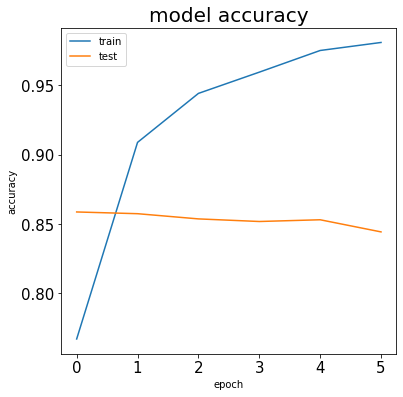

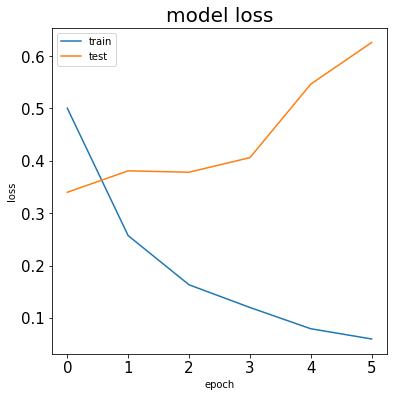

In [ ]:
plot_loss_accuracy_training(history)

Añadiendo la capa de Dropout se ha obtenido un F1 del 86.1%, ligeramente inferior a la obtenida sin la capa, pero si que se observa que hasta la epoch 3 el loss se mantenía más o menos estable.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, lstm_model_tuning)

Precision: 0.849 Recall 0.874 F1 score: 0.861 for Neuronal Network


#### 3.6.2 Anadir una capa de Densa

Ya que el modelo que mejor funciona solo tiene una capa recurrente, puede ser interesante probar que pasa si se añaden más capas densas al modelo. En este caso se ha añadido una capa de 50 neuronas (la mitad de las neuronas de la capa LSTM) y su correspondiente capa de Dropout.

In [ ]:
lstm_model_tuning = Sequential()
lstm_model_tuning.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
lstm_model_tuning.add(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5))
lstm_model_tuning.add(Dropout(0.5))
lstm_model_tuning.add(Dense(units=50))
lstm_model_tuning.add(Dropout(0.5))
lstm_model_tuning.add(Dense(classes, activation='softmax'))

lstm_model_tuning.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
lstm_model_tuning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          3218100   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 3,303,652
Trainable params: 3,303,652
Non-

In [ ]:
history = lstm_model_tuning.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 203s 983ms/step - loss: 0.4836 - acc: 0.7723 - val_loss: 0.3496 - val_acc: 0.8450
Epoch 2/40
200/200 [==============================] - 196s 978ms/step - loss: 0.2539 - acc: 0.9148 - val_loss: 0.3710 - val_acc: 0.8381
Epoch 3/40
200/200 [==============================] - 195s 976ms/step - loss: 0.1626 - acc: 0.9473 - val_loss: 0.4952 - val_acc: 0.8600
Epoch 4/40
200/200 [==============================] - 207s 1s/step - loss: 0.1084 - acc: 0.9641 - val_loss: 0.5797 - val_acc: 0.8462
Epoch 5/40
200/200 [==============================] - 195s 974ms/step - loss: 0.0744 - acc: 0.9772 - val_loss: 0.6569 - val_acc: 0.8562
Epoch 6/40
200/200 [==============================] - 196s 978ms/step - loss: 0.0620 - acc: 0.9853 - val_loss: 0.8826 - val_acc: 0.8363


Se ha obtenido un F1 del 86.4%, mejorando así el caso anterior sin capa densa, pero aún sin superar el modelo de una capa. El número de parámetros no varía a penas, salvo que se añaden 5050 parámetros más de la capa densa.

Esta opción puede tener sentido utilizarlo ya que da resultados parecidos sin añadir prácticamente coste.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, lstm_model_tuning)

Precision: 0.819 Recall 0.915 F1 score: 0.864 for Neuronal Network


#### 3.6.3 Cambio de la función de coste

Otra opción posible es cambiar la función de coste por la de Mean Squared Error, para ver si así podemos tratar de evitar que aumente tan rápidamente el loss.

In [ ]:
lstm_model_tuning = Sequential()
lstm_model_tuning.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
lstm_model_tuning.add(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5))
lstm_model_tuning.add(Dense(classes, activation='softmax'))

lstm_model_tuning.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['acc'])
lstm_model_tuning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,298,702
Trainable params: 3,298,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model_tuning.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 203s 1s/step - loss: 0.1593 - acc: 0.7767 - val_loss: 0.1054 - val_acc: 0.8556
Epoch 2/40
200/200 [==============================] - 198s 993ms/step - loss: 0.0689 - acc: 0.9148 - val_loss: 0.1047 - val_acc: 0.8662
Epoch 3/40
200/200 [==============================] - 194s 970ms/step - loss: 0.0409 - acc: 0.9481 - val_loss: 0.1208 - val_acc: 0.8375
Epoch 4/40
200/200 [==============================] - 195s 973ms/step - loss: 0.0266 - acc: 0.9661 - val_loss: 0.1157 - val_acc: 0.8469
Epoch 5/40
200/200 [==============================] - 195s 973ms/step - loss: 0.0194 - acc: 0.9770 - val_loss: 0.1200 - val_acc: 0.8413
Epoch 6/40
200/200 [==============================] - 199s 997ms/step - loss: 0.0146 - acc: 0.9825 - val_loss: 0.1336 - val_acc: 0.8375
Epoch 7/40
200/200 [==============================] - 195s 976ms/step - loss: 0.0081 - acc: 0.9906 - val_loss: 0.1278 - val_acc: 0.8531


Como se puede ver, los resultados en cuanto a F1 no han mejorado significativamente, sin embargo si que se ha reducino notablemente la loss del modelo, que a penas a aumentado durante el entrenamiento. En el caso base se obtuvo una loss final del 0.5929 frente a 0.1278 obtenida en este caso. Por lo que parece que esta función de coste reduce significativamente el loss.

In [ ]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, lstm_model_tuning)

Precision: 0.853 Recall 0.873 F1 score: 0.863 for Neuronal Network


#### 3.6.4 Dos capas Bidireccionales apiladas

Por último se va a probar el funcionamiento de dos capas bidireccionales de LSTM apiladas, el modelo más complejo hasta ahora, para ver si al combinar estas dos opciones, se mejoran los resultadod de aplicarlas por separado.

In [13]:
lstm_model_tuning = Sequential()
lstm_model_tuning.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
lstm_model_tuning.add(Bidirectional(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5, return_sequences=True)))
lstm_model_tuning.add(Bidirectional(LSTM(units=emb_dim, dropout=0.2, recurrent_dropout=0.5)))
lstm_model_tuning.add(Dense(classes, activation='softmax'))

lstm_model_tuning.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
lstm_model_tuning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          3218100   
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 3,620,102
Trainable params: 3,620,102
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = lstm_model_tuning.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_acc, early_stopping_loss])

Epoch 1/40
200/200 [==============================] - 921s 5s/step - loss: 0.1505 - acc: 0.7695 - val_loss: 0.1200 - val_acc: 0.8331
Epoch 2/40
200/200 [==============================] - 908s 5s/step - loss: 0.0438 - acc: 0.9441 - val_loss: 0.1310 - val_acc: 0.8131
Epoch 3/40
200/200 [==============================] - 905s 5s/step - loss: 0.0271 - acc: 0.9666 - val_loss: 0.1336 - val_acc: 0.8356
Epoch 4/40
200/200 [==============================] - 932s 5s/step - loss: 0.0145 - acc: 0.9834 - val_loss: 0.1339 - val_acc: 0.8456
Epoch 5/40
200/200 [==============================] - 943s 5s/step - loss: 0.0111 - acc: 0.9872 - val_loss: 0.1577 - val_acc: 0.8062
Epoch 6/40
200/200 [==============================] - 943s 5s/step - loss: 0.0089 - acc: 0.9898 - val_loss: 0.1459 - val_acc: 0.8263


En esta ocasión no vemos tampoco mejores resultados que en las anteriores pruebas, si no que se ha reducido un poco la F1, un 0.6% para el caso de la capa Bidireccional simple, y un 0.2% para el caso de las apiladas. 

En cualquier caso este modelo no merecen la pena debido al largo tiempo de enterenamiento que supone y la cantidad de parámetros que tiene en comparación con modelos más simples y mejores resultados.

In [15]:
evaluate_nn_classifier(tensor_x_test, binary_y_test, lstm_model_tuning)

Precision: 0.765 Recall 0.937 F1 score: 0.843 for Neuronal Network


## 4 Conclusiones

Como conclusión del trabajo, se puede decir que las RNN funcionan muy bien en cuanto a texto se refiere, ya que con una única capa recurrente se consiguien resultados muy bueno.

También es sorprendente que modelos más complejos como las capas apiladas o bidireccionales, o incluso añadir capas densas extra, no hagan mejorar el modelo, si no más bien empeorarlo ligeramente. Lo que indica que no siempre un modelo más complejo va a funcionar mejor en según que casos.

Sería interesante haber probado más aspectos, como las funciones de activación y el número de neronas, pero creo que era más interesante probar a que nivel mejoran o empeoran las distintas capas los resultados. En este caso la capa con mayor número de parámetros (LSTM) ha resultado ser la mejor opción.

Si nos basamos en los resultados obtenidos en la práctica anterior (CNN) se puede ver unos resultados similares, lo que resulta sorprendente ya que en teoría las RNN funcionan mejor a nivel de texto, pero los resultados tan similares pueden ser debido al conjunto de entranemiento que se está utilizando.

